# Notebook Accompanying Email #5: Signals.

## Looking at Seasonality

## Magic

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import datetime as dt
import numpy as np
import plotnine as p9
import polars as pl
import pandas as pd
import yfinance as yf

## Options / Globals

In [3]:
p9.options.figure_size = (9, 5)

## Get ^GSPC Data and Conver to Polars DataFrame

In [4]:
tickers = yf.Ticker('^GSPC')

In [5]:
px = pl.from_dataframe(
    tickers
    .history(period='max', auto_adjust=False)
    .reset_index()
    .assign(Date=lambda x: pd.to_datetime(x['Date']).dt.tz_localize(None))
)

## Create Returns and Rolling 20-Day Average of Returns

In [6]:
N = 20

data = (
    px
    .with_columns(
        pl.col('Adj Close').pct_change().alias('ret')   # create returns defined as ret(t) = Px(t) / Px(t-1) - 1
    )
    .with_columns(
        pl.col('ret').rolling_mean(window_size=N, min_periods=N).alias('ret_ma'),  # create moving average of returns
        (pl.col('ret') * pl.col('ret')).alias('ret_2'), # calculate returns squared
    )
    .with_columns(
        pl.col('ret_2').ewm_mean(alpha=1.0/N, min_periods=N,ignore_nulls=False, adjust=False).sqrt().alias('rolling_vol'),  # calculate exponential moving average of returns squared
        pl.col('Date').dt.month().alias('month'),  # need month and year to obtain tradeday of month
        pl.col('Date').dt.year().alias('year'),
        ((pl.col('Date').dt.year() - 1900) // 20 + 1).alias('bidecade')  # for robustness checks we group dates into groups of 20 years
    )
    .group_by(['month', 'year'], maintain_order=True)
    .agg(pl.all())
    .with_columns(
        pl.col('Date')
        .list.eval(pl.int_range(1, pl.len()+1))
        .alias('tradeday')
    )
    .explode(pl.exclude('month', 'year'))
    .drop_nulls()
    .select('Date', 'Close', 'ret', 'ret_ma', 'ret_2', 'rolling_vol', 'tradeday', 'bidecade')
)

## Plot Returns and Rolling 20-Day Average of Returns

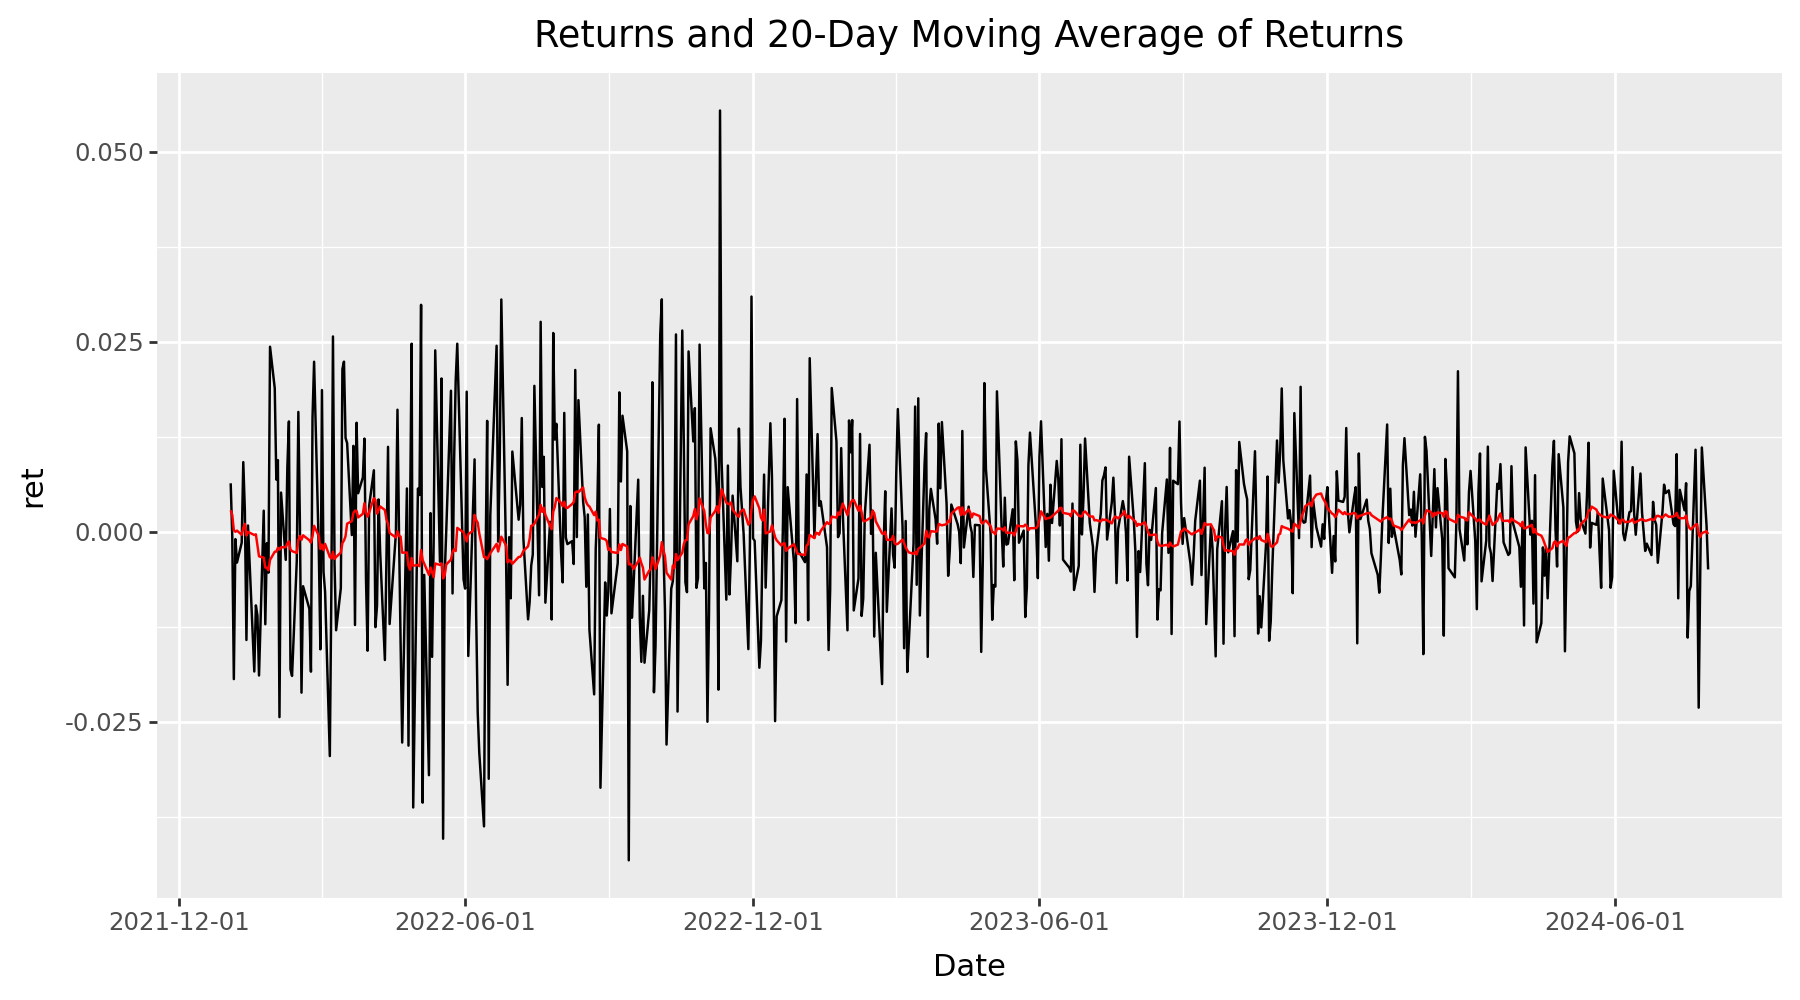

In [7]:
(
    data
    .filter(
        pl.col('Date') > dt.datetime(2022, 1, 1)
    )
    .pipe(p9.ggplot)
    + p9.aes(x='Date')
    + p9.geom_line(p9.aes(y='ret'))
    + p9.geom_line(p9.aes(y='ret_ma'), color='red')
    + p9.ggtitle("Returns and 20-Day Moving Average of Returns")
)

## Plot Returns and Rolling 20-Day Average of Returns

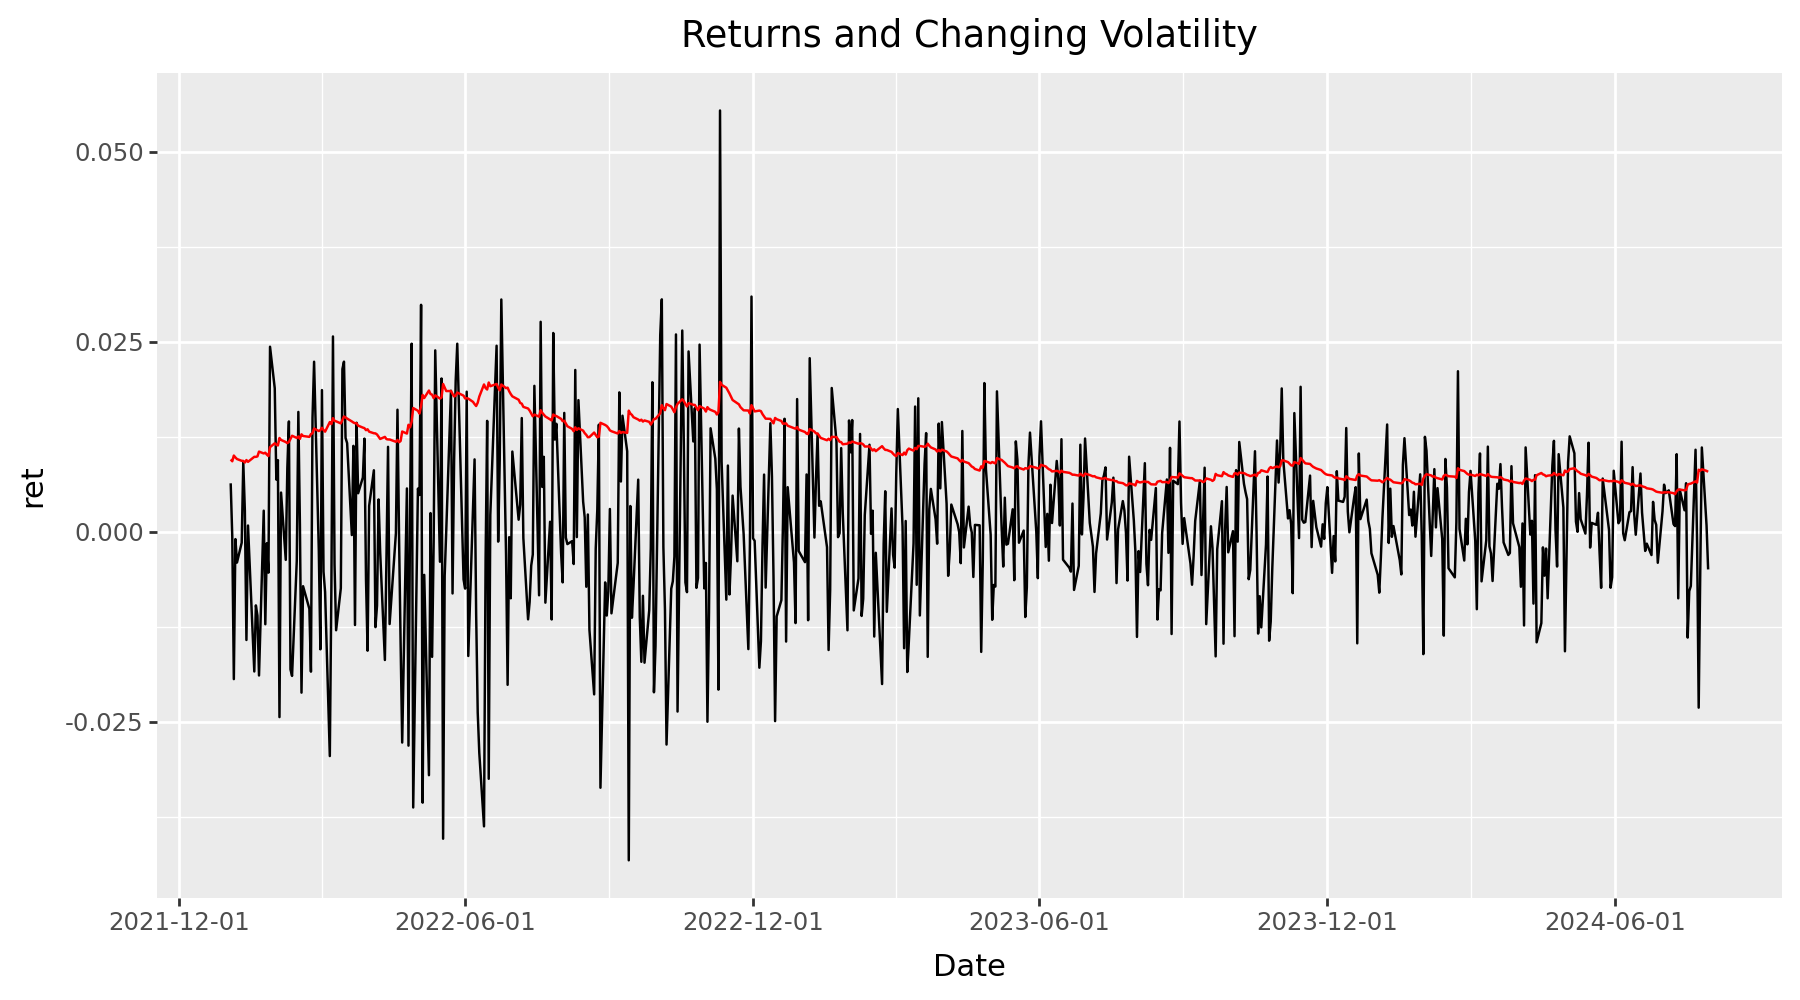

In [8]:
(
    data
    .filter(
        pl.col('Date') > dt.datetime(2022, 1, 1)
    )
    .pipe(p9.ggplot)
    + p9.aes(x='Date') #, y='ret')
    + p9.geom_line(p9.aes(y='ret'))
    + p9.geom_line(p9.aes(y='rolling_vol'), color='red')
    + p9.ggtitle('Returns and Changing Volatility')
)

## Returns for Tradedays

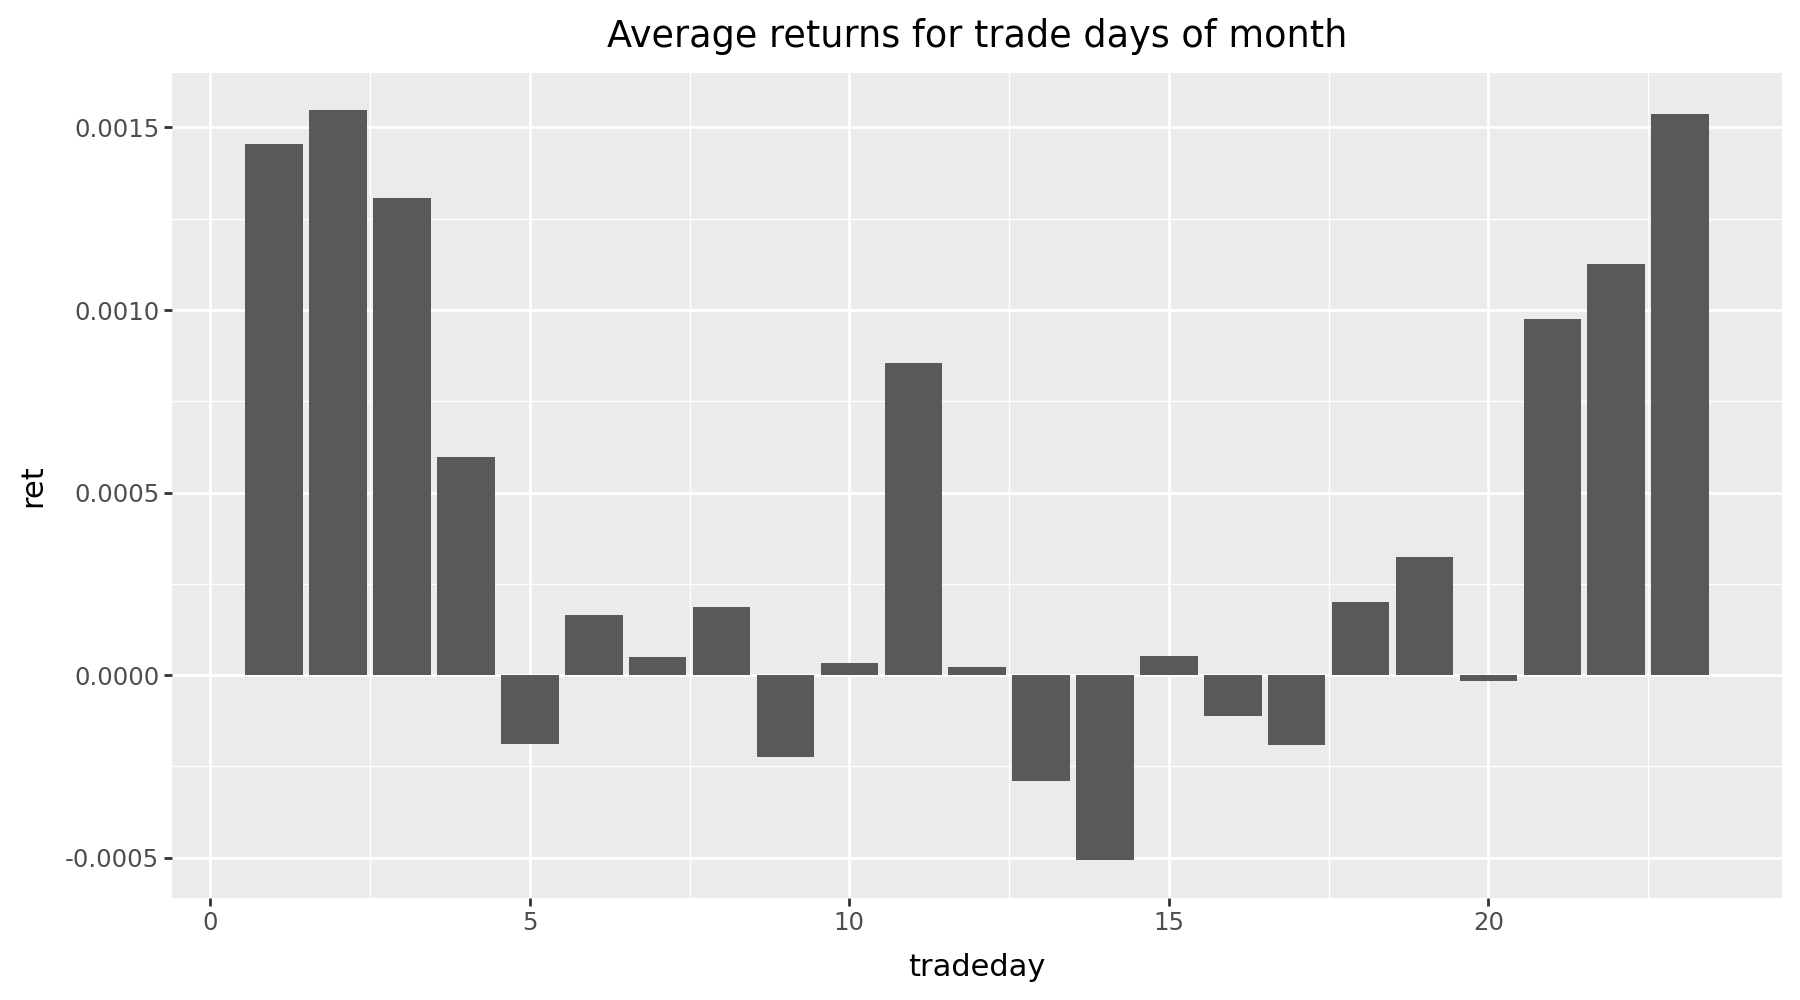

In [9]:
(
    data
    .group_by('tradeday', maintain_order=True)
    .agg(
        pl.col('ret').mean()
    )
    .sort('tradeday')
    .pipe(p9.ggplot)
    + p9.aes(x='tradeday', y='ret')
    + p9.geom_bar(stat='identity')
    + p9.ggtitle('Average returns for trade days of month')
)

## Robustness

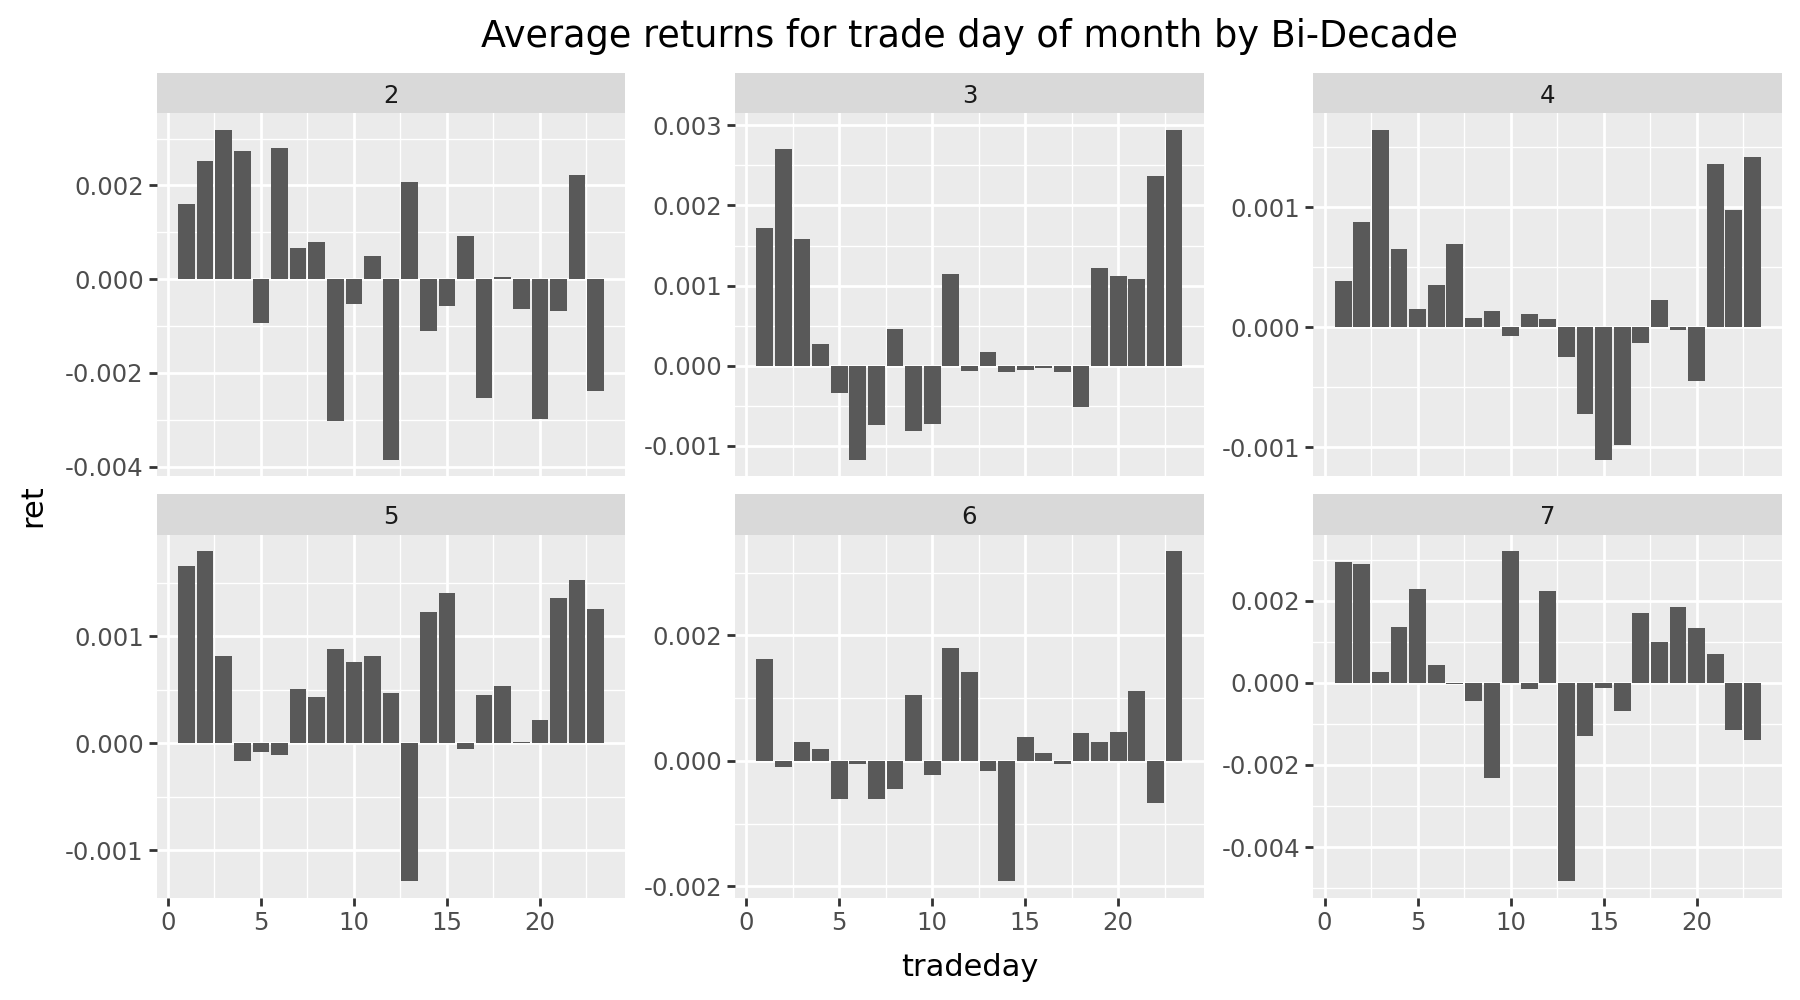

In [10]:
(
    data
    .group_by(['bidecade', 'tradeday'], maintain_order=True)
    .agg(
        pl.col('ret').mean()
    )
    .sort(['bidecade', 'tradeday'])
    .pipe(p9.ggplot)
    + p9.aes(x='tradeday', y='ret')
    + p9.geom_bar(stat='identity')
    + p9.facet_wrap('bidecade', scales='free_y')
    + p9.ggtitle('Average returns for trade day of month by Bi-Decade')
)

## Naive Strategy

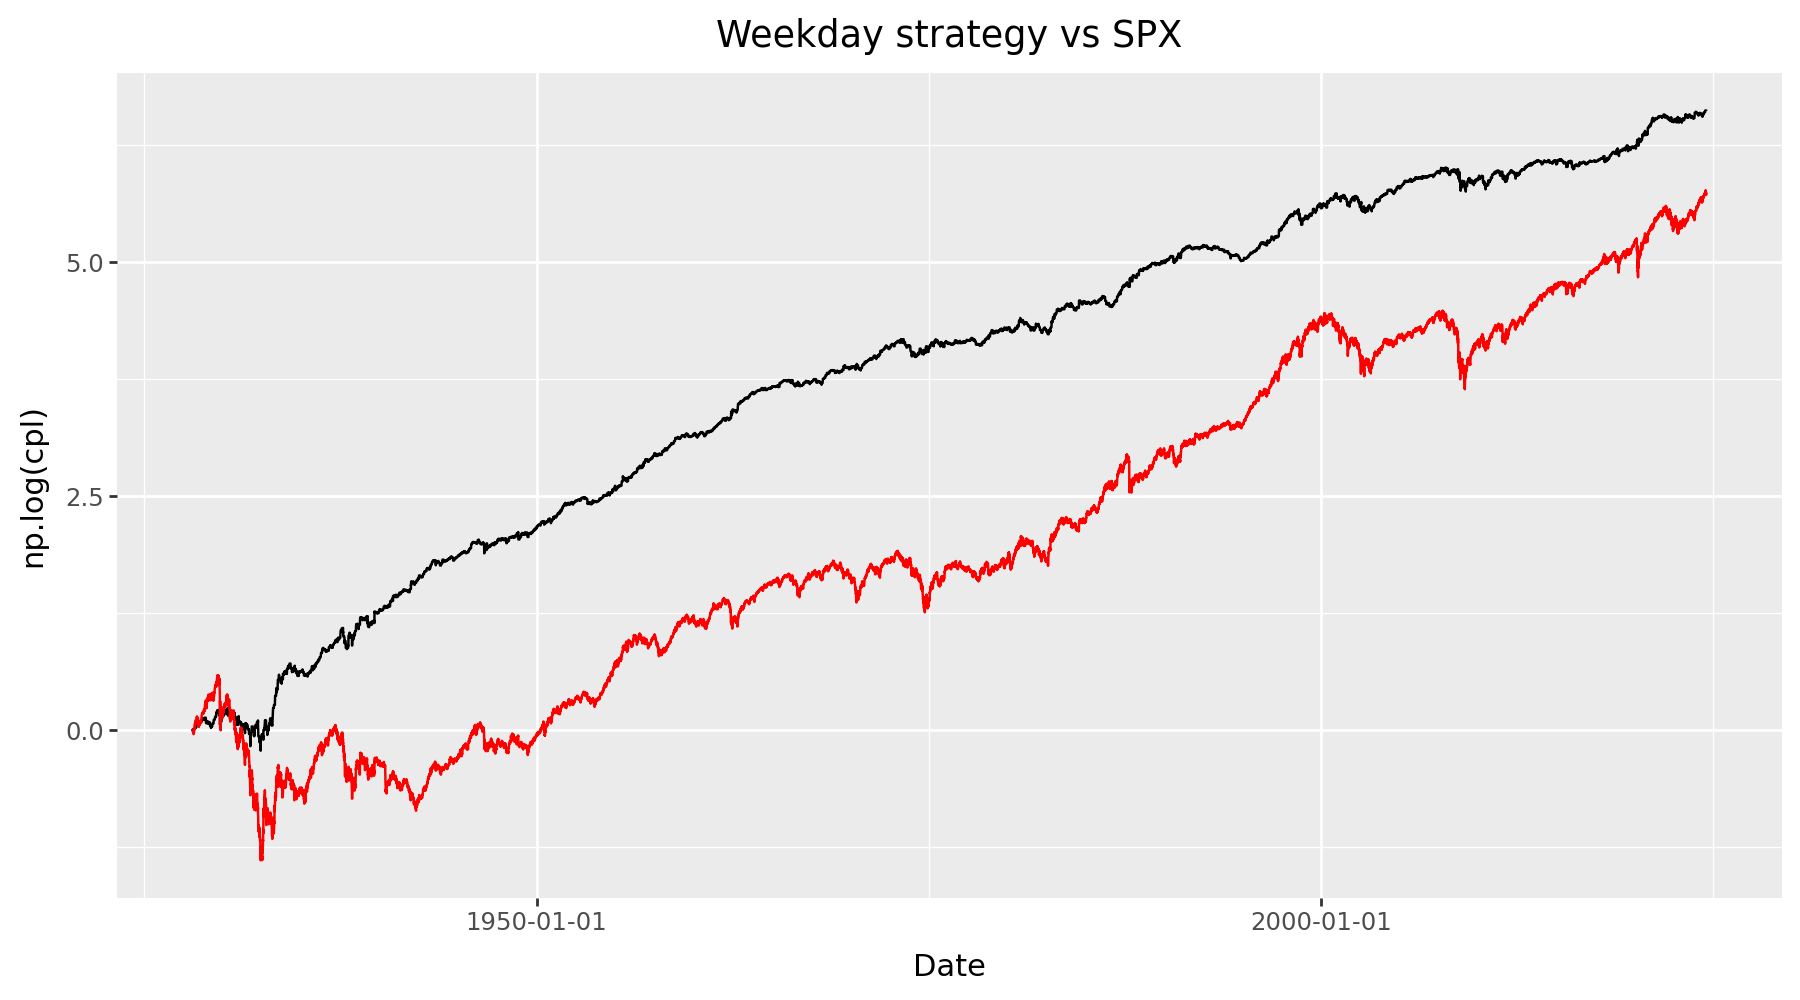

In [11]:
(
    data
    .with_columns(
        pl.when((pl.col('tradeday') < 5) | (pl.col('tradeday') > 20)).then(1).otherwise(0).alias('flag')
    )
    .with_columns(
        (1 + pl.col('flag') * pl.col('ret')).cum_prod().alias('cpl'),
        (1 + pl.col('ret')).cum_prod().alias('spx')
    )
    .pipe(p9.ggplot)
    + p9.aes(x = 'Date')
    + p9.geom_line(p9.aes(y='np.log(cpl)'))
    + p9.geom_line(p9.aes(y='np.log(spx)'), color='red')
    + p9.ggtitle('Weekday strategy vs SPX')
)

## Risk Exposure

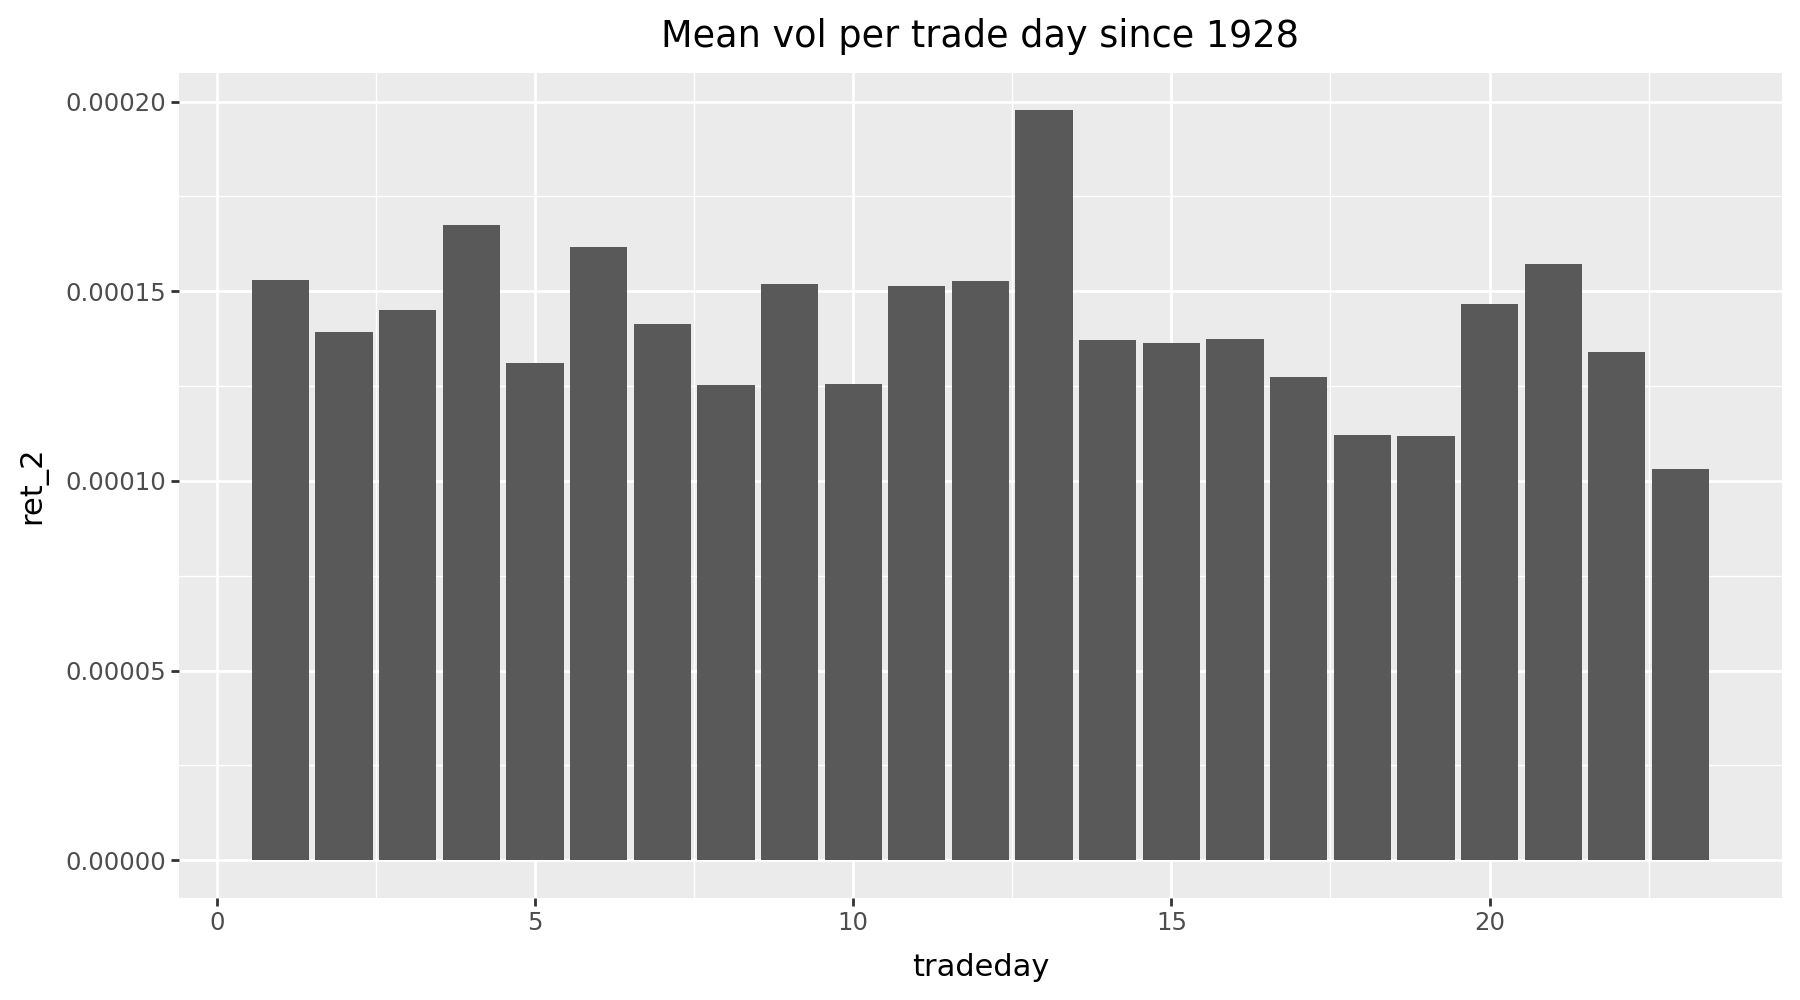

In [12]:
(
    data
    .group_by('tradeday')
    .agg(pl.col('ret_2').mean())
    .sort('tradeday')
    .pipe(p9.ggplot)
    + p9.aes(x='tradeday', y='ret_2')
    + p9.geom_bar(stat='identity')
    + p9.ggtitle('Mean vol per trade day since 1928')
)